In [5]:
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [6]:
from wikipedia_cleanup.data_processing import get_data
from wikipedia_cleanup.data_filter import generate_default_filters, KeepAttributesDataFilter, OnlyUpdatesDataFilter

In [7]:
# Set RAM Limit
import resource
  
def limit_memory(maxsize):
    soft, hard = resource.getrlimit(resource.RLIMIT_AS)
    resource.setrlimit(resource.RLIMIT_AS, (maxsize, hard))
limit_memory(84000000000)

# Enable Code Completion
%config Completer.use_jedi = False

Load data

In [8]:
data = get_data('../../custom-format-default-filtered/', n_jobs=0, filters=[OnlyUpdatesDataFilter(), KeepAttributesDataFilter(['infobox_key', 'page_title', 'property_name', 'template',\
                                                                                                     'previous_value', 'current_value', 'value_valid_from'])])

585it [43:03,  4.42s/it]


In [9]:
data = data[data['property_name']!='']

In [ ]:
data = data.rename(columns={"value_valid_from": "timestamp"})
data['timestamp'] = pd.to_datetime(data['timestamp'])

Groupby property name and template type to get median and avg change frequencies

In [36]:
tqdm.pandas()

In [36]:
static_data[:10].index

MultiIndex([(          'genre',              'infobox album'),
            (    'currentclub', 'infobox football biography'),
            (          'genre',     'infobox musical artist'),
            (          'genre',             'infobox single'),
            (     'clubnumber', 'infobox football biography'),
            (       'starring',               'infobox film'),
            (     'birth_date',             'infobox person'),
            ('associated_acts',     'infobox musical artist'),
            (           'misc',              'infobox album'),
            (    'birth_place',             'infobox person')],
           names=['property_name', 'template'])

In [30]:
g = data.sort_values('timestamp').groupby(['infobox_key','property_name','template'])

In [ ]:
avg_time_diff = g.progress_apply(lambda x: x['timestamp'].diff().mean()).reset_index()

  0%|          | 0/6734016 [00:00<?, ?it/s]

In [ ]:
median_time_diff = g.progress_apply(lambda x: x['timestamp'].diff().median()).reset_index()

In [41]:
avg_time_diff.rename(columns={0:'avgChangeFrequ'},inplace=True)
median_time_diff.rename(columns={0:'medianChangeFrequ'},inplace=True)

In [46]:
ten_years = pd.Timedelta(weeks = 520)

In [47]:
avg_time_diff['avgChangeFrequ'].fillna(ten_years, inplace=True)
median_time_diff['medianChangeFrequ'].fillna(ten_years,inplace=True)

In [54]:
g_avg = avg_time_diff.groupby(['property_name','template'])['avgChangeFrequ'].mean(numeric_only=False)
g_med = median_time_diff.groupby(['property_name','template'])['medianChangeFrequ'].median(numeric_only=False)

In [61]:
# label everything with more than 13 months change frequ as static
avg_static = g_avg > pd.Timedelta(weeks = 56)
median_static = g_med > pd.Timedelta(weeks = 56)

In [71]:
avg_static_infoboxes = g_avg[avg_static].index.to_frame(index=False)
avg_dynamic_infoboxes = g_avg[~avg_static].index.to_frame(index=False)
median_static_infoboxes = g_med[median_static].index.to_frame(index=False)
median_dynamic_infoboxes = g_med[~median_static].index.to_frame(index=False)

Saving

In [81]:
avg_static_infoboxes.to_csv('../data/avg_static.csv',index=False)
avg_dynamic_infoboxes.to_csv('../data/avg_dynamic.csv',index=False)
median_static_infoboxes.to_csv('../data/median_static.csv',index=False)
median_dynamic_infoboxes.to_csv('../data/median_dynamic.csv',index=False)

Plotting

In [10]:
avg_static_infoboxes = pd.read_csv('../data/avg_static.csv')
avg_dynamic_infoboxes = pd.read_csv('../data/avg_dynamic.csv')
median_static_infoboxes = pd.read_csv('../data/median_static.csv')
median_dynamic_infoboxes = pd.read_csv('../data/median_dynamic.csv')

In [11]:
avg_static_tuples = [tuple(v) for v in avg_static_infoboxes.values]
avg_dynamic_tuples = [tuple(v) for v in avg_dynamic_infoboxes.values]
median_static_tuples = [tuple(v) for v in median_static_infoboxes.values]
median_dynamic_tuples = [tuple(v) for v in median_dynamic_infoboxes.values]

In [19]:
g = data.groupby(['property_name','template'])['infobox_key'].count()

In [23]:
g.index.isin(avg_static_tuples)

array([ True, False, False, ..., False, False, False])

In [24]:
static_data = g[g.index.isin(avg_static_tuples)]
dynamic_data = g[g.index.isin(avg_dynamic_tuples)]

In [31]:
static_data = static_data.sort_values(ascending=False)
dynamic_data = dynamic_data.sort_values(ascending=False)

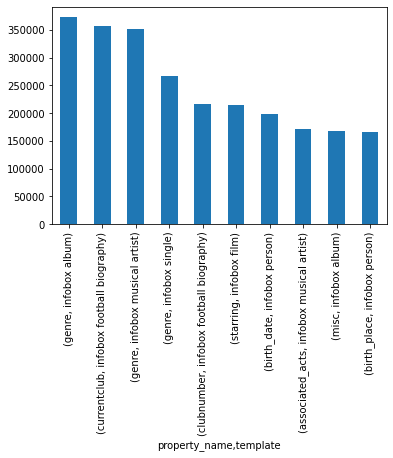

In [34]:
static_data[:10].plot.bar()
plt.show()

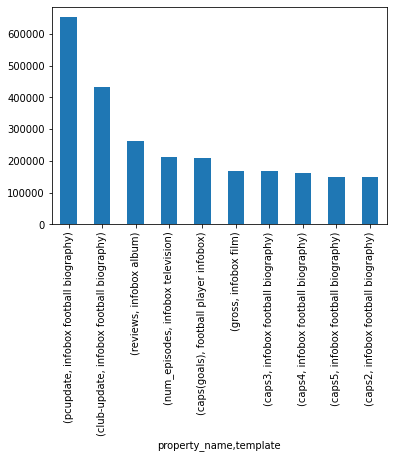

In [35]:
dynamic_data[:10].plot.bar()
plt.show()

In [ ]:
plt.figure(figsize=(12,5))
plt.boxplot(avg_static_infoboxes[:10].values,\
           labels=avg_static_infoboxes[:10].index)
plt.title('Count of static property, template pairs')
plt.ylabel('Count of static infobox occurences')
plt.xlabel('Property template pair')
plt.show()

In [ ]:
plt.figure(figsize=(12,5))
plt.bar(avg_dynamic_infoboxes[:10].values,\
        labels=avg_dynamic_infoboxes[:10].index)
plt.title('Count of dynamic property, template pairs')
plt.ylabel('Count of dynamic infobox occurences')
plt.xlabel('Property template pair')
plt.show()